In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
df =pd.read_csv("AirPassengers.csv")
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
df.columns

Index(['Month', '#Passengers'], dtype='object')

In [4]:
df["Month"]=pd.to_datetime(df["Month"])
df

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [5]:
df.dtypes

Month          datetime64[ns]
#Passengers             int64
dtype: object

In [6]:
df.set_index("Month",inplace=True)
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


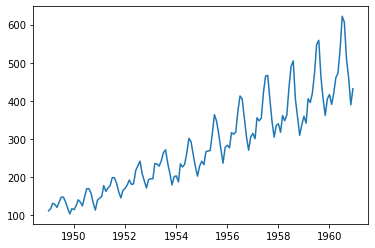

In [7]:
plt.plot(df["#Passengers"])

In [8]:
from statsmodels.tsa.stattools import adfuller
adf,pvalue,usedlag_,nobs_,critical_values_,icbest_=adfuller(df)

In [9]:
print(pvalue) #if pvalue > 0.05 then data is not stationary

0.9918802434376411


In [10]:
df["year"]=[d.year for d in df.index]
df

,#Passengers,year
Month,,
1949-01-01,112,1949
1949-02-01,118,1949
1949-03-01,132,1949
1949-04-01,129,1949
1949-05-01,121,1949
...,...,...
1960-08-01,606,1960
1960-09-01,508,1960
1960-10-01,461,1960


In [11]:
df["month"]=[d.strftime('%b') for d in df.index]
df

,#Passengers,year,month
Month,,,
1949-01-01,112,1949,Jan
1949-02-01,118,1949,Feb
1949-03-01,132,1949,Mar
1949-04-01,129,1949,Apr
1949-05-01,121,1949,May
...,...,...,...
1960-08-01,606,1960,Aug
1960-09-01,508,1960,Sep
1960-10-01,461,1960,Oct


In [12]:
years=df['year'].unique()
years

array([1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960])

<AxesSubplot:xlabel='year', ylabel='#Passengers'>

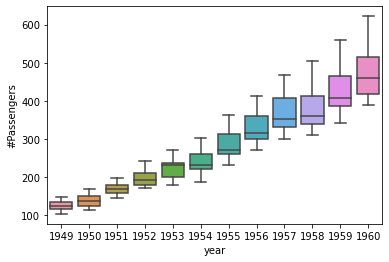

In [13]:
sns.boxplot(x='year',y='#Passengers',data=df)

<AxesSubplot:xlabel='month', ylabel='#Passengers'>

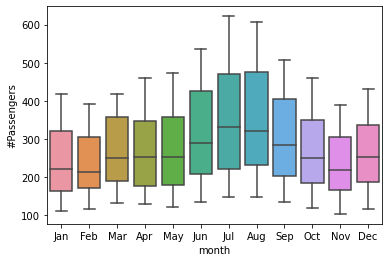

In [14]:
sns.boxplot(x='month',y='#Passengers',data=df)

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed=seasonal_decompose(df["#Passengers"],
                             model='additive'
                             )

In [16]:
trend=decomposed.trend
sesonal=decomposed.seasonal
residual=decomposed.resid

In [17]:
trend

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: trend, Length: 144, dtype: float64

In [18]:
sesonal

Month
1949-01-01   -24.748737
1949-02-01   -36.188131
1949-03-01    -2.241162
1949-04-01    -8.036616
1949-05-01    -4.506313
                ...    
1960-08-01    62.823232
1960-09-01    16.520202
1960-10-01   -20.642677
1960-11-01   -53.593434
1960-12-01   -28.619949
Name: seasonal, Length: 144, dtype: float64

In [19]:
residual

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: resid, Length: 144, dtype: float64

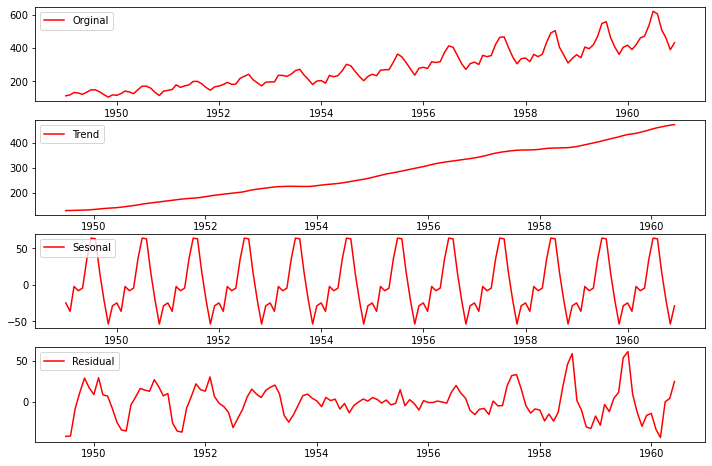

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df["#Passengers"],label="Orginal",color='red')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label="Trend",color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sesonal,label="Sesonal",color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual,label="Residual",color='red')
plt.legend(loc='upper left')
plt.show()

In [21]:
from pmdarima.arima import auto_arima

In [22]:
arima_model=auto_arima(df["#Passengers"],start_p=1,d=1,start_q=1,
                      max_p=5,max_q=5,max_d=5,m=12,
                        start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.52 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.31 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.35 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.35 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.50 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [23]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Thu, 05 Aug 2021   AIC                           1019.178
Time:                                     12:56:26   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
size=int(len(df)*0.66)
X_train,X_test=df[0:size],df[size:len(df)]

In [25]:
X_train.shape

(95, 3)

In [26]:
X_test.shape

(49, 3)

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [28]:
model=SARIMAX(X_train["#Passengers"],
             order=(0,1,1),
             seasonal_order=(2,1,1,12))
result=model.fit()
result.summary()

/home/venom/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/venom/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.269
Date:                            Thu, 05 Aug 2021   AIC                            610.538
Time:                                    12:56:27   BIC                            622.571
Sample:                                01-01-1949   HQIC                           615.369
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3178      0.105     -3.033      0.002      -0.523      -0.112
ar.S.L12       0.6852      0.592      1.158      0.247      -0.475       1.845
ar.S.L24       0.3138      0.138      2.266      0.023       0.042       0.585
ma.S.L12      -0.9825      5.733     -0.171      0.864     -12.219      10.254
sigma2        78.5119    403.082      0.195      0.846    -711.513     868.537
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.96   Prob(JB):                         0.28
Heteroskedasticity (H):               1.69   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
start_index=0
end_index=len(X_train)-1
train_predction=result.predict(start_index,end_index)
train_predction

1949-01-01      0.000000
1949-02-01    111.998315
1949-03-01    117.999819
1949-04-01    131.999579
1949-05-01    129.000090
                 ...    
1956-07-01    419.513161
1956-08-01    398.684677
1956-09-01    365.463275
1956-10-01    320.685306
1956-11-01    274.815284
Freq: MS, Name: predicted_mean, Length: 95, dtype: float64

In [30]:
st_index=len(X_train)
ed_index=len(df)-1
predction=result.predict(st_index,ed_index)
predction

1956-12-01    311.078201
1957-01-01    320.218054
1957-02-01    310.916399
1957-03-01    351.804911
1957-04-01    349.823670
1957-05-01    354.994094
1957-06-01    411.773950
1957-07-01    456.938004
1957-08-01    444.948734
1957-09-01    395.727857
1957-10-01    347.038794
1957-11-01    309.180914
1957-12-01    352.228027
1958-01-01    361.323130
1958-02-01    351.071818
1958-03-01    394.451681
1958-04-01    391.971236
1958-05-01    398.513451
1958-06-01    459.278968
1958-07-01    505.529284
1958-08-01    493.630224
1958-09-01    440.236935
1958-10-01    388.309655
1958-11-01    349.120977
1958-12-01    393.913258
1959-01-01    403.962834
1959-02-01    392.338639
1959-03-01    437.704422
1959-04-01    435.515300
1959-05-01    443.050976
1959-06-01    506.792267
1959-07-01    555.720911
1959-08-01    542.632022
1959-09-01    486.624125
1959-10-01    432.575481
1959-11-01    391.578233
1959-12-01    438.497858
1960-01-01    449.187428
1960-02-01    436.324535
1960-03-01    483.832798


<AxesSubplot:xlabel='Month'>

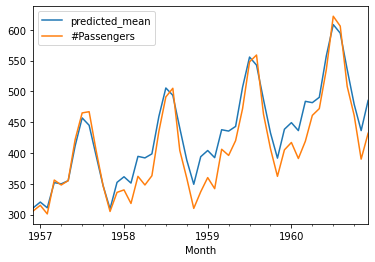

In [31]:
predction.plot(legend=True)
X_test["#Passengers"].plot(legend=True)

In [32]:
import math
from sklearn.metrics import mean_squared_error

In [33]:
trainScore=math.sqrt(mean_squared_error(X_train['#Passengers'],train_predction))
testScore=math.sqrt(mean_squared_error(X_test["#Passengers"],predction))
trainScore,testScore

(16.14314770795587, 29.30672362400131)

In [34]:
forcast=result.predict(start=len(df),
                      end=(len(df)-1)+3*12,
                      typ="levels").rename('Forecust')

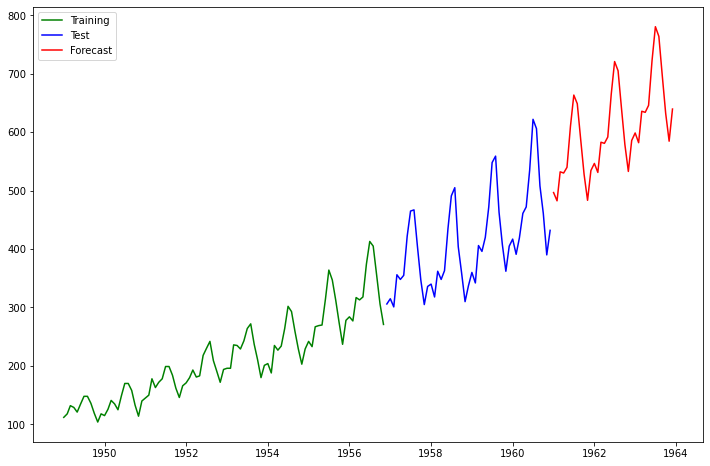

In [35]:
plt.figure(figsize=(12,8))
plt.plot(X_train["#Passengers"],label="Training",color='green')
plt.plot(X_test["#Passengers"],label="Test",color='blue')
plt.plot(forcast,label="Forecast",color="red")
plt.legend(loc="upper left")
